In [3]:
#need to run this notebook using: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

1. Take a square out of the center of each image equal to the shortest edge
2. Redimension the square so that all squares are of equal size
3. Reshape it into a tiling
4. Append the tiled arrays to a single DataFrame of width equal to the size of one tile as a 1D vector multiplied by 3 RGB channels
5. Run a 1D SOM on a random selection of the tiles (this will constitute the alphabet of the images)
6. Project them back to all the tiles
7. Reshape the array back into tiles where the BMU replaces the RGB pixels of each tile (this is the signature of each image).
8. Run another SOM

In [1]:
import random
from PIL import Image
import numpy as np
%load_ext autotime
from matplotlib import pyplot as plt
%matplotlib inline
import sompylib.sompy as SOM
from sompylib.sompy import denormalize_by
import datetime

ModuleNotFoundError: No module named 'autotime'

In [2]:
import glob
#filelist = glob.glob("C:\Users\doyle\Dropbox\Teaching\entwerfen\Exercise_1\Photos\*.jpg")
filelist = glob.glob("/Users/mrdoyle/Dropbox/Teaching/entwerfen/Exercise_1/Photos/*.jpg")
#filelist = glob.glob("/Users/mrdoyle/Dropbox/Screensaver/*.jpg")

time: 4.27 ms


In [13]:
length, width = 200, 200
crop_length, crop_width = 50, 50
portion_size = (length,width)

image_sq = []

for j in filelist:
    im = Image.open(j)
    if np.asarray(im).shape[0] > length and np.asarray(im).shape[1] > width and len(np.asarray(im).shape)==3:
        for x in range(0,300):
            image_size = im.size
            x1 = random.randint(0, image_size[0]-portion_size[0]-1)
            y1 = random.randint(0, image_size[1]-portion_size[1]-1)
            x2, y2 = x1+portion_size[0]-1, y1+portion_size[1]-1
            crop_rectangle = (x1, y1, x2, y2)
            cropped_im = im.crop(crop_rectangle)
            resize = cropped_im.resize((crop_length,crop_width))
            image_sq.append(np.asarray(resize)[:,:,:3].reshape(crop_length*crop_width*3))
            #image_sq.append(np.asarray(resize)[:,:].reshape(10000))
    else:
        print np.asarray(im).shape

time: 1min 13s


In [14]:
len(image_sq)

59100

time: 3.35 ms


In [159]:
plt.imshow(image_sq[1].reshape(10,100,3))

IndexError: list index out of range

time: 15.8 ms


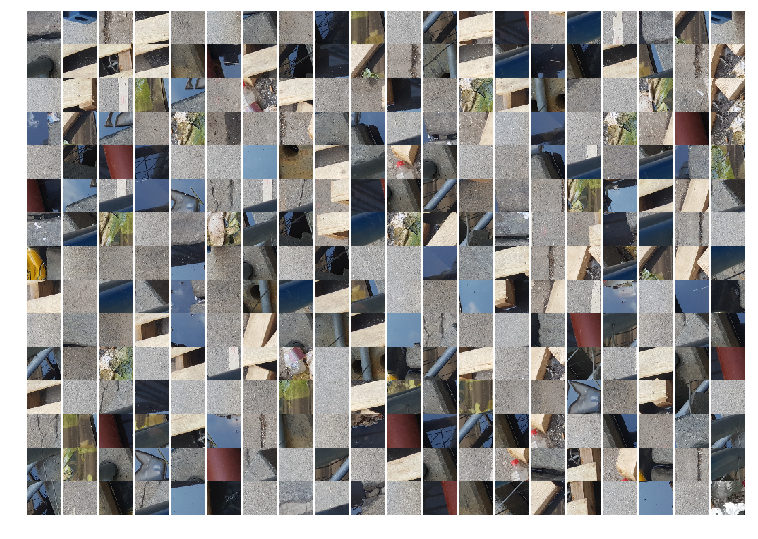

time: 49.6 s


In [22]:
# Display the original tiles
w,h = 20,15
fig  = plt.figure(figsize=(10,10*h/w)) # (width, height)
c = 0;
for i in range(h):
    for j in range(w):
        ax = fig.add_subplot(15,20,c+1, aspect='equal') #laying down the height and then the width
        c = c+1
        fig.subplots_adjust(0,0,1,1,0,0)
        try:
            ax.imshow(image_sq[c].reshape(crop_length,crop_width,3))
            ax.axis('off')
        except: 
            ax.axis('off')
            pass

In [17]:
np.asarray(image_sq).shape

(59100, 7500)

time: 326 ms


In [32]:
# Prepare the global conditions for the SOM
import warnings
warnings.filterwarnings('ignore')

image_sq_arr = np.asarray(image_sq)

perc = 10

msz0 = 50
msz1 = 50
images = image_sq_arr[np.random.choice(image_sq_arr.shape[0], int(float(perc)/100*image_sq_arr.shape[0]), replace=True), :]
#CN_val[np.random.choice(CN_val.shape[0], int(float(sample_perc)/100*CN_val.shape[0]), replace=True), :]

# Run a SOM and extract the codebook
sm = SOM.SOM('', images, mapsize = [msz0, msz1],norm_method = 'var',initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'no')#, verbose='on')
cb = sm.codebook[:]
cb_n = denormalize_by(sm.data_raw, sm.codebook[:], n_method='var')


initialization method = pca, initializing..

initialization done in 1.848000 seconds

rough training...
radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 13

epoch: 1 ---> elapsed time:  9.568000, quantization error: 69.037768 

epoch: 2 ---> elapsed time:  9.101000, quantization error: 69.373428 

epoch: 3 ---> elapsed time:  9.850000, quantization error: 45.888017 

epoch: 4 ---> elapsed time:  10.571000, quantization error: 41.399832 

epoch: 5 ---> elapsed time:  10.044000, quantization error: 40.102916 

epoch: 6 ---> elapsed time:  9.998000, quantization error: 39.435984 

epoch: 7 ---> elapsed time:  9.793000, quantization error: 38.894838 

epoch: 8 ---> elapsed time:  10.213000, quantization error: 38.382072 

epoch: 9 ---> elapsed time:  9.879000, quantization error: 37.835648 

epoch: 10 ---> elapsed time:  11.467000, quantization error: 37.245458 

epoch: 11 ---> elapsed time:  12.346000, quantization error: 36.614970 

epoch: 12 ---> elapsed time:  13.476000, quant

In [33]:
# Project to the original data points
import pandas as pd
data = image_sq

sm.cluster_labels = np.asarray(["" for i in range(sm.nnodes)])
bmus = sm.project_data(data)
im_bmus = pd.DataFrame(data)
im_bmus['bmus'] = bmus
im_bmus.head()

0    1    2    3    4    5    6    7    8    9  ...   7491  7492  7493  \
0  177  176  174  157  155  156  171  170  168  178  ...     51    72    99   
1  146  142  143  174  170  169  123  119  120  127  ...    126   130   139   
2   19   35   60   23   39   64   18   34   59   28  ...    184   183   179   
3  152  144  141  163  158  155  170  162  159  149  ...    110   103    95   
4   58   57   62   35   35   37   64   64   66   41  ...     40    38    39   

   7494  7495  7496  7497  7498  7499  bmus  
0    50    71    98    49    70    97  1764  
1   136   143   153   132   136   148  1572  
2   163   162   157   176   173   168  1734  
3   245   228   210   188   164   136  2022  
4    41    39    40    42    40    43  1835  

[5 rows x 7501 columns]

time: 26min 55s


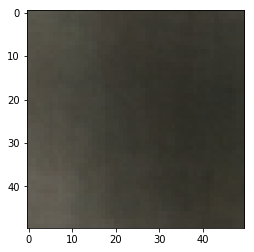

time: 211 ms


In [31]:
plt.imshow(cb_n[50].reshape(crop_length,crop_width,3)/255)

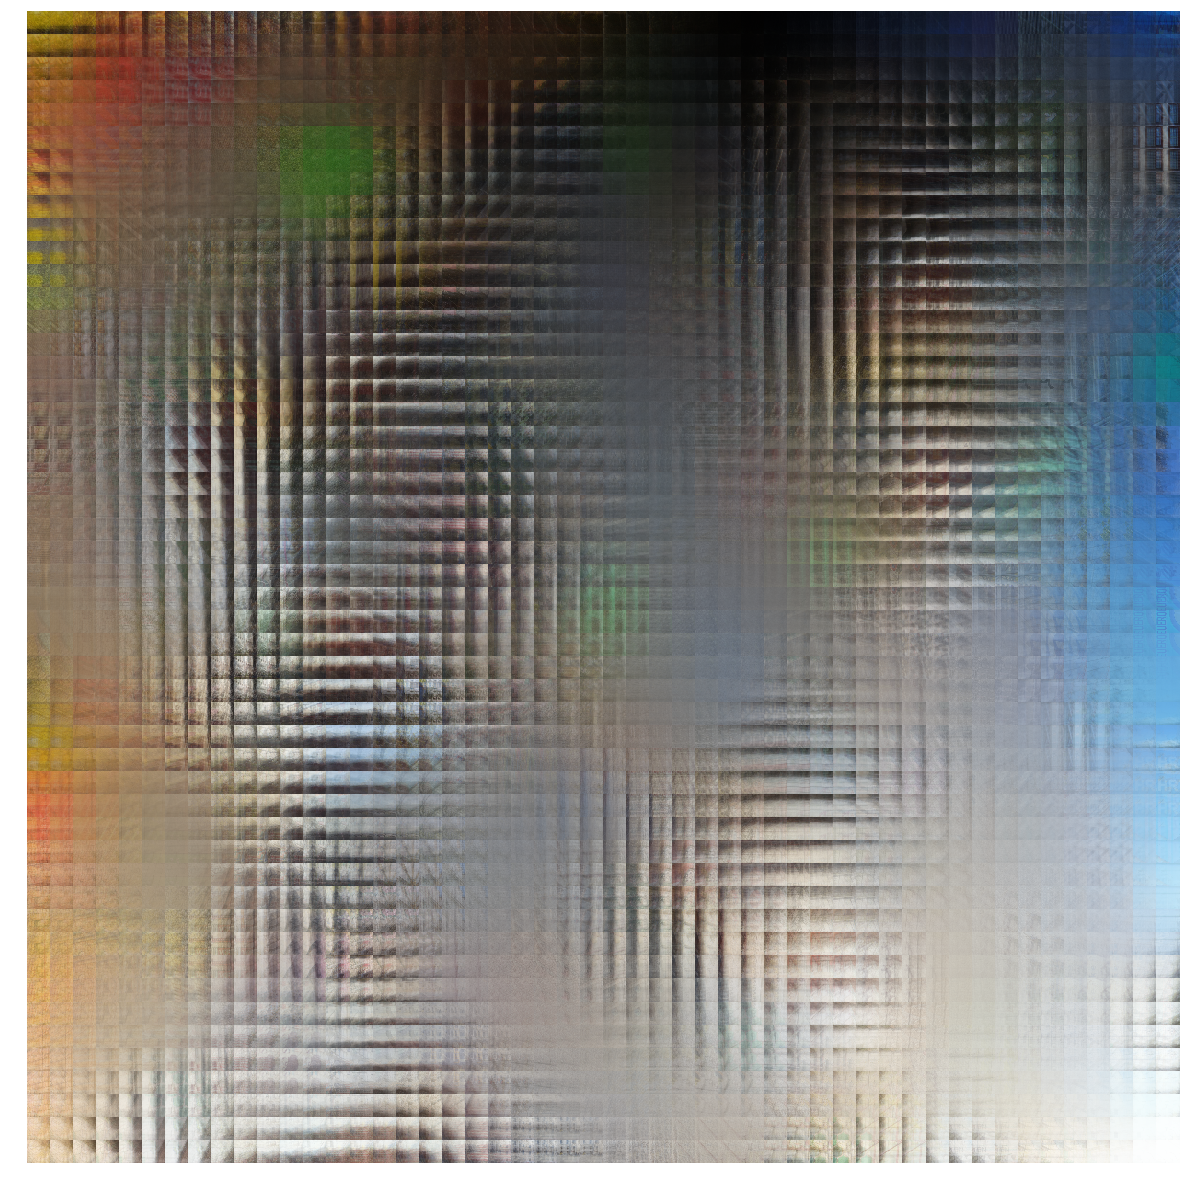

time: 14min 40s


In [34]:
# Plotting the codebook
datetime.datetime.now()
fig  = plt.figure(figsize=(16,16))
c = 0;
for i in range(msz1):
    for j in range(msz0):
        #plt.subplot(msz0,msz1,c+1)
        ax = fig.add_subplot(msz0,msz1,c+1, aspect='equal')
        ind = bmus == c
        fig.subplots_adjust(0,0,1,1,0,0)
        try:
            ax.imshow(cb_n[c].reshape(crop_length,crop_width,3)/255)#,cmap='gray')
            ax.axis('off')
        except: 
            #ax.imshow(cb_n[c].reshape(50,50,3)/255)#.astype(float)/255)#,cmap='gray') ax.axis('off')
            ax.axis('off')
        else:
            ax.axis('off')
            pass
        c = c+1

In [66]:
outpath = '/Users/mrdoyle/Dropbox/Teaching/entwerfen/Exercise_1/SOM/codebook40x40.jpg'
fig.savefig(outpath,dpi=300)

time: 6.42 s


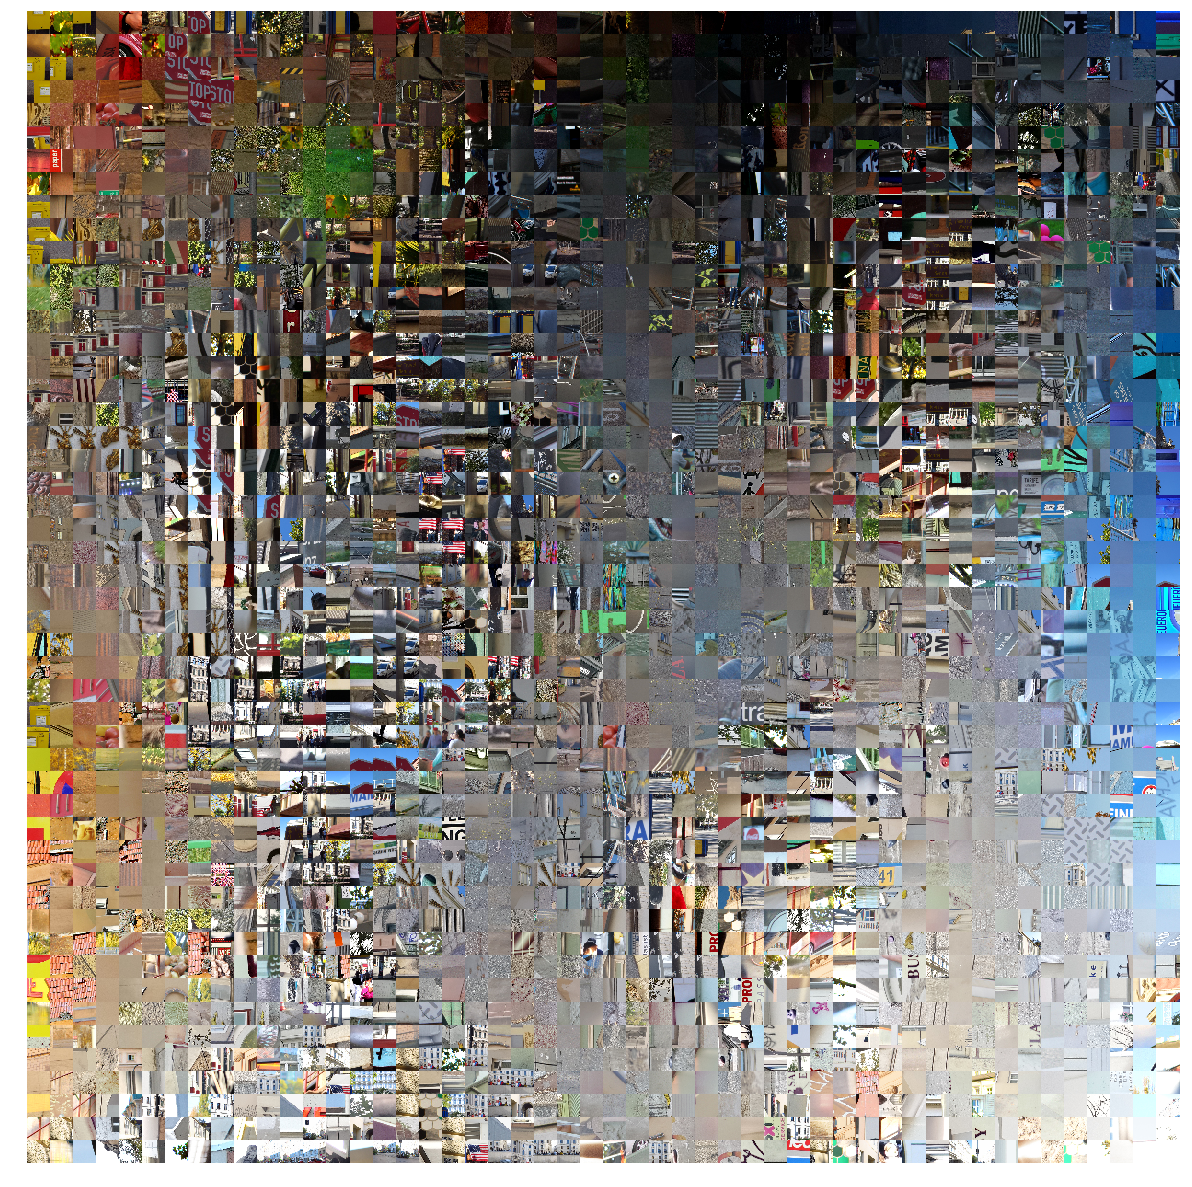

time: 15min


In [35]:
# Plotting the original tiles
datetime.datetime.now()
fig1  = plt.figure(figsize=(16,16))
c = 0;
for i in range(msz1):
    for j in range(msz0):
        #plt.subplot(msz0,msz1,c+1)
        ax = fig1.add_subplot(msz0,msz1,c+1, aspect='equal')
        ind = bmus == c
        fig1.subplots_adjust(0,0,1,1,0,0)
        try:
            ax.imshow(im_bmus[im_bmus['bmus']==c].sample(n=1).values[:,:crop_length*crop_width*3].reshape(crop_length,crop_width,3).astype(float)/255)#,cmap='gray')
            ax.axis('off')
        except: 
            ax.imshow(cb_n[c].reshape(crop_length,crop_width,3)/255)#.astype(float)/255)#,cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
            pass
        c = c+1

In [67]:
outpath = '/Users/mrdoyle/Dropbox/Teaching/entwerfen/Exercise_1/SOM/orig-as-nodes40x40.jpg'
fig1.savefig(outpath,dpi=300)

time: 3.88 s


In [20]:
image_size = im.size
portion_size = (301, 301)
image_sq = []

for x in range(0, 20):
    x1 = random.randint(0, image_size[0]-portion_size[0]-1)
    y1 = random.randint(0, image_size[1]-portion_size[1]-1)
    x2, y2 = x1+portion_size[0]-1, y1+portion_size[1]-1
    crop_rectangle = (x1, y1, x2, y2)
    cropped_im = im.crop(crop_rectangle)
    image_sq.append(np.asarray(cropped_im).reshape(270000))
    cropped_im

In [38]:
len(image_sq)

3920

[array([72, 80, 99, ..., 93, 73, 84], dtype=uint8),
 array([255, 252, 255, ..., 137, 132, 154], dtype=uint8),
 array([166, 167, 185, ..., 242, 245, 255], dtype=uint8)]

In [ ]:
y2